## Script to create CRC STR and Splice Event pairs that occur within the same gene. The correlation between the CRC STR mean length and the Splice Event PSI for tumor samples will be calculated

## Analysis for SplAdder data


In [1]:
# Imports required  packages 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import ensembl_rest
import gseapy as gp
from collections import Counter

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Read CRC STR meta
crc_samples_meta_data = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/CRC_msi.csv")
# Remove Patient TCGA-F5-6810 because the meta data information are empty
crc_samples_meta_data = crc_samples_meta_data[crc_samples_meta_data['patient'] != 'TCGA-F5-6810']
# Get list of all patients 
patients_in_metadata = crc_samples_meta_data['patient'].to_list()

In [3]:
def create_str_pivot(coad_data, read_data, str_meta_data):
    """
    This method creats a pivot table for given CRC STR data. Each column represents a patient. The values are the mean length of the STR over all patients

    Args:
        coad_data (str): path to COAD data
        read_data (str): path to READ data
        str_meta_data (str): path to STR meta data 

    Returns:
        pivot_annotated: annotated pivot table
        pivot_df: pivot table
    """

    # Read STR data
    df_coad = pd.read_csv(coad_data)
    df_read = pd.read_csv(read_data)
    # Read STR annotation
    df_str_annotated = pd.read_csv(str_meta_data, sep='\t')
    # Create sub-data frame with the given columns
    df_str_annotated = df_str_annotated[['tmp_id', 'gene_names', 'gene_ensembl_ids']]

    # Combine COAD and READ STR
    df = df_read.append(df_coad)
    # Calculate STR mean length
    df['mean_length'] = (df['allele_a'] + df['allele_b']) / 2

    # Create STR pivot table -> for each STR and tumor sample the table contains the STR mean length
    pivot_df = pd.pivot_table(df, 
                            index='tmp_id', 
                            columns='sample', 
                            values=['mean_length'], 
                            aggfunc='mean',
                            fill_value=0)

    # Set column names
    pivot_df.columns = [col[1] for col in pivot_df.columns]
    pivot_df_copy = pivot_df.copy()
    # Cut column names 
    pivot_df_copy.columns = ['-'.join(col.split('-')[:3]) for col in pivot_df_copy.columns]
    # Remove STR with same length over all tumor samples
    pivot_df = pivot_df_copy.drop_duplicates(keep=False)
    # Count zero values for each row
    zero_counts = pivot_df.eq(0).sum(axis=1)
    # Count non-zero values for each row
    non_zero_counts = pivot_df.ne(0).sum(axis=1)
    # Filter rows where the number of zeros is less than or equal to the number of non-zero values
    pivot_df = pivot_df[(zero_counts <= non_zero_counts)]

    # Reset indices to column
    pivot_df.reset_index(inplace=True)
    # Replace "_" by "-" in column names
    pivot_df.rename(columns=lambda x: x.replace('_', '-'), inplace=True)
    # Rename 'tmp-id' column
    pivot_df.rename(columns={'tmp-id': 'tmp_id'}, inplace=True)
    # Merge pivor_ df with annotation file -> create annotated CRC STRs
    pivot_annotated = pd.merge(pivot_df, df_str_annotated, on='tmp_id', how='inner')
    # Relocate columns
    cols = list(pivot_annotated.columns)
    cols.insert(1, cols.pop(cols.index('gene_names')))
    cols.insert(2, cols.pop(cols.index('gene_ensembl_ids')))
    pivot_annotated = pivot_annotated[cols]
    # Remove duplicated columns
    pivot_annotated = pivot_annotated.loc[:, ~pivot_annotated.columns.duplicated()]
    # Return (annotated) pivot table
    return pivot_annotated, pivot_df

In [4]:
def process_str_ase(ase_data, pivot_annotated):
    """
    This method process the splicing data by selection the column (patients) that have STR data available.

    Args:
        ase_data (str): path to splicing data
        pivot_annotated (pd.Dataframe: annotated CRC STR pivot table

    Returns:
        df_SplAdder (pd.Dataframe): splicing data frame
        pivot_annotated (pd.Dataframe): annotated STR pivot table
        cols_str_ase_spladder (list): list of patients available in splicing data frame
    """
    
    #Import Splicing Event dataset
    df_SplAdder = pd.read_csv(ase_data, sep='\t')
    # Remove duplicated rows. SplAdder provides COAD and READ data in separate files. It is assumed that these have been merged by the user, therefore duplicates may occur.
    df_SplAdder = df_SplAdder.drop_duplicates()

    # Split ASE tumor samples names -> create same name structure like STR (to compare STR and ASE samples)
    cols_to_modify = df_SplAdder.columns[15:]
    df_SplAdder.rename(columns={col: '-'.join(col.split('-')[:3]) for col in cols_to_modify}, inplace=True)
    # Remove duplicated columns
    df_SplAdder = df_SplAdder.loc[:, ~df_SplAdder.columns.duplicated()]
    # Columns of STR data
    cols_str_spladder = pivot_annotated.columns[1:].tolist() 
    # Columns of ASE data
    cols_ase_spladder = df_SplAdder.columns[15:].tolist()
    # Get patients that have ASE and meta data available
    patients_in_metadata_and_spladder = list(set(cols_ase_spladder).intersection(set(patients_in_metadata)))
    
    # Get tumor samples that are in STR and ASE data -> 370 patients 
    cols_str_ase_spladder = set(patients_in_metadata_and_spladder).intersection(cols_str_spladder) 
    # Convert set 'cols_str_ase' to list
    cols_str_ase_spladder = list(cols_str_ase_spladder)
    # Create STR with tumor samples and the first 3 columns of the original columns ("tmp_id", "gene_names", "gene_ensembl_ids")
    pivot_annotated = pivot_annotated[list(pivot_annotated.columns[:3]) + cols_str_ase_spladder]
    # Create ASE table with tumor samples and the first 15 columns
    df_SplAdder = df_SplAdder[list(df_SplAdder.columns[:15]) + cols_str_ase_spladder]
    # Rename column 'GeneSymbol' in ASE data to 'gene_names'
    df_SplAdder.rename(columns={'GeneSymbol': 'gene_names'}, inplace=True)
    # count zero-values for each rows
    ase_zero_counts = df_SplAdder.iloc[:, 15:].apply(lambda row: row.isin([0, np.nan]).sum(), axis=1)
    # count non zero-values for each rows
    ase_non_zero_counts = (df_SplAdder.iloc[:, 15:] != 0).sum(axis=1) & df_SplAdder.iloc[:, 15:].notna().sum(axis=1)
    # Filter rows where the number of zeros is lesser than or equal
    df_SplAdder = df_SplAdder[(ase_zero_counts <= ase_non_zero_counts)]
    # return ASE table, pivot table and the names of the patients that have STR and ASE data
    return df_SplAdder, pivot_annotated, cols_str_ase_spladder


def merge_str_ase(df_ASE, pivot_annotated):
    """
    Method to merge splicing events and STR to create pairs of splicing events and STR that are within the same gene.

    Args:
        df_ASE (pd.Dataframe): Data frame of splicing events
        pivot_annotated (pd.Dataframe): annotated pivot table that contains the STR length

    Returns:
        pd.Dataframe: pairs of splicing events and annotated STR
    """
    # Merge annotated CRC STR and SplAdder ASE -> create pairs of ASE and STR that occur within the same gene
    str_ase = pd.merge(pivot_annotated, df_ASE, on='gene_names', how='inner')
    # Delete duplicated based on the column tmp_id', 'gene_ensembl_ids'
    str_ase = str_ase.drop_duplicates(subset=['tmp_id', 'SpliceEvent'])
    return str_ase


def calculare_correlation(str_ase, pivot_annotated, df_SplAdder):
    """
    This method calculates the pearson correlation coefficient of the PSI vlaues and mean STR length over all patients for each splicing-STR pair.

    Args:
        str_ase (pd.Dataframe): Pairs of splicing events and STR

    Returns:
        df_str_ase (pd.Dataframe): Calculated pearson corrleation coefficient 
    """
    # Create sub data frame of STR and ASE pairs with the following columns 
    str_ase_pairs = str_ase[['tmp_id','SpliceEvent', 'gene_names', 'GeneID']]

    # Create empty data frame to save the calculated correlation
    df_str_ase = pd.DataFrame(columns=['crc_str', 'splice_event', 'gene_name', 'pearson_coefficient', 'p_value'])

    # Iterate over len of STR-ASE pairs 
    print(len(str_ase_pairs))
    for i in range(len(str_ase_pairs)):
        # Select STR
        crc_str = pivot_annotated[pivot_annotated['tmp_id'] == str_ase_pairs['tmp_id'].iloc[i]].iloc[:,3:].iloc[0].tolist()
        # Select ASE
        ase = df_SplAdder[df_SplAdder['SpliceEvent'] == str_ase_pairs['SpliceEvent'].iloc[i]].iloc[:, 15:].iloc[0].tolist()
        # Create data frame of the selected STR and ASE
        data = {'crc_str': crc_str,'ase': ase}
        # Create a DataFrame
        df = pd.DataFrame(data)
        # Fill 'NaN' values with 0
        df = df.fillna(0)
        # Calculate pearson_coefficient and p_value for each STR-ASE pair
        correlation_coefficient, p_value = pearsonr(df['crc_str'], df['ase'])
        # Fill data frame for each ASE-STR pair
        str_ase = {'crc_str': str_ase_pairs['tmp_id'].iloc[i], 
                    'splice_event': str_ase_pairs['SpliceEvent'].iloc[i],
                    'gene_name': str_ase_pairs['gene_names'].iloc[i],
                    'gene_id': str_ase_pairs['GeneID'].iloc[i],
                    'pearson_coefficient': correlation_coefficient,
                    'p_value': p_value}
        # Append results to data frame 
        df_str_ase = df_str_ase.append(str_ase, ignore_index=True)
        # Counter to see how far the calculations are
        if i % 1000 == 0:
            print(i)
    # Sort data frame by 'pearson_coefficient'
    df_str_ase = df_str_ase.sort_values(by='pearson_coefficient', ascending=False)
    return df_str_ase


def get_gene_info(gene_name_list, info):
    """
    Mezhod to get the gene funczion of a given list of gene names using the 'Ensemble.api'

    Args:
        gene_name_list (list): Gene names
        info (string): to select which information the user want to get

    Returns:
        _type_: _description_
    """
    # create empty dictionary to save the genes and their functions. Gene names are the keys and the function are saved as the values
    gene_functions = {}
    # Try catch block if no function could be found for a gene
    try:
        # Iterate over all genes in the given list
        for gene in gene_name_list:
            # Get ensemble information for each gene
            gene_function = ensembl_rest.symbol_lookup(
                    species='homo sapiens',
                    symbol=gene)
            # Save the gene and its function in the dictionary 
            gene_functions[gene] = gene_function[info]
    except:
        # If no functuon could be found then the function will be labeled as 'None'
        gene_functions[gene] = None
    return gene_functions  

In [5]:
if __name__=='__main__':
    """
    Execute the functions
    """
    
    pivot_annotated, pivot_df = create_str_pivot("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/COAD_pt.csv", 
                                                 "/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/READ_pt.csv", 
                                                 "/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/tral_and_perf_panel_meta_info_updated.tsv")

    df_SplAdder, pivot_annotated, cols_str_ase_spladder =  process_str_ase("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/Spladder_PSI_COAD_and_READ.tsv", 
                                                                           pivot_annotated)

    spladder_str_ase = merge_str_ase(df_SplAdder, 
                                     pivot_annotated)

    df_str_ase_spladder = calculare_correlation(spladder_str_ase, 
                                                pivot_annotated,
                                                df_SplAdder)
    df_str_ase_spladder = df_str_ase_spladder[['crc_str', 'splice_event', 'gene_name', 'gene_id' ,'pearson_coefficient', 'p_value']]

64125
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000


In [6]:
# Mask to filter rosw in df_str_ase_spladder that have a p_value  1 > p_value > 0
mask = (df_str_ase_spladder['p_value'] >= 0) & (df_str_ase_spladder['p_value'] <= 1)
df_str_ase_spladder = df_str_ase_spladder[mask]

# Calculate adjusted p_value using benjamini hochberg correction
df_str_ase_spladder['adjusted_p_value'] = multipletests(df_str_ase_spladder['p_value'], alpha=0.05, method='fdr_bh')[1].tolist()

# Sort out gender chromosoms 
mask = ~df_str_ase_spladder['crc_str'].str.contains('chrX|chrY')
df_str_ase_spladder = df_str_ase_spladder[mask]

# Create subset with filtered rows based on the adjusted p_value
df_str_ase_spladder_filtered = df_str_ase_spladder[(df_str_ase_spladder['adjusted_p_value'] < 0.05)]

# Get the ene function of the 
gene_fuction = get_gene_info(df_str_ase_spladder_filtered['gene_name'], 'description')

# Map the function of the genes to genes
df_str_ase_spladder_filtered['gene_function'] = df_str_ase_spladder_filtered['gene_name'].map(gene_fuction)

df_str_ase_spladder_filtered['gene_id'] = df_str_ase_spladder_filtered['gene_id'].str.split('.').str[0]
df_str_ase_spladder['str_ase_pairs'] = df_str_ase_spladder['crc_str']+ '; id:' +df_str_ase_spladder['splice_event'] 

# Count how many gene ar in the STR-ASE pairs (used filtered data frame)
genes_counts = df_str_ase_spladder_filtered['gene_name'].value_counts()

df_str_ase_spladder_filtered.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/filtered_SplAdder_STR_ASE_pairs_correlation.csv")
df_str_ase_spladder.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/SplAdder_STR_ASE_pairs_correlation.csv")

In [17]:
#spladder_str_ase.columns.to_list()
spladder_str_ase[['tmp_id','gene_names','gene_ensembl_ids','SpliceEvent','SpliceType','EventRegion']].to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/SplAdder_STR_ASE_pairs.csv")

### P-value Plot

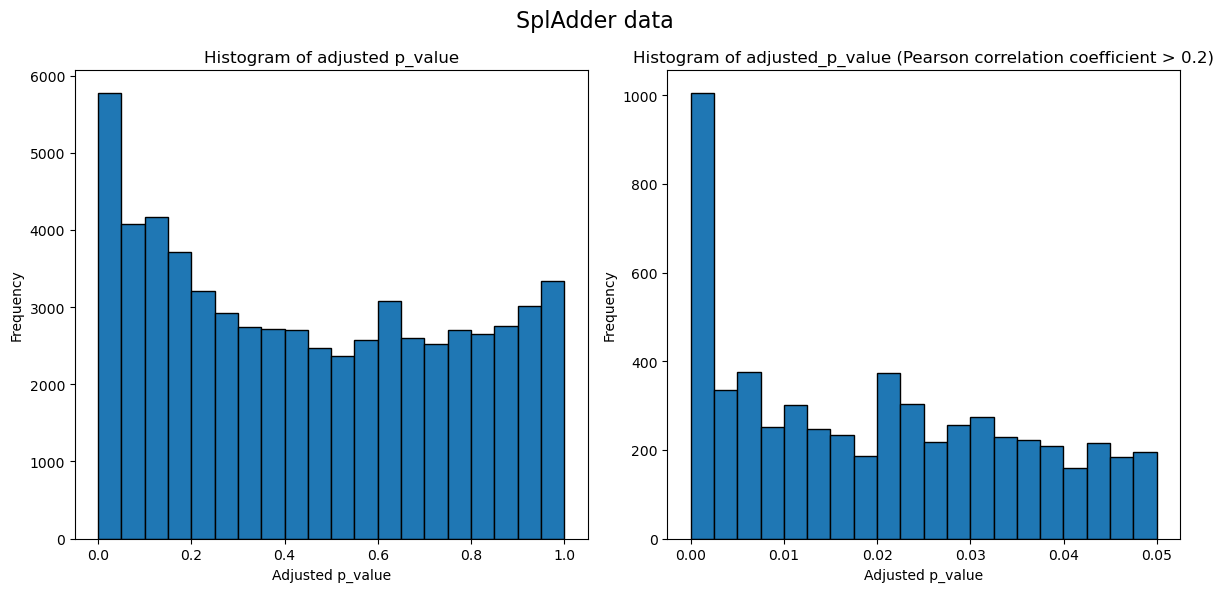

In [18]:
def create_pval_figures(df_str_ase, df_str_ase_filtered, db_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot the first histogram
    axes[0].hist(df_str_ase['adjusted_p_value'], bins=20, edgecolor='black')
    axes[0].set_xlabel('Adjusted p_value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Histogram of adjusted p_value')

    # Plot the second histogram
    axes[1].hist(df_str_ase_filtered['adjusted_p_value'], bins=20, edgecolor='black')
    axes[1].set_xlabel('Adjusted p_value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Histogram of adjusted_p_value (Pearson correlation coefficient > 0.2)')

    if db_name == 'SplAdder': 
        fig.suptitle('SplAdder data', fontsize=16)
    else:
        fig.suptitle('SpliceSeq data', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()

create_pval_figures(df_str_ase_spladder, df_str_ase_spladder_filtered, 'SplAdder')    

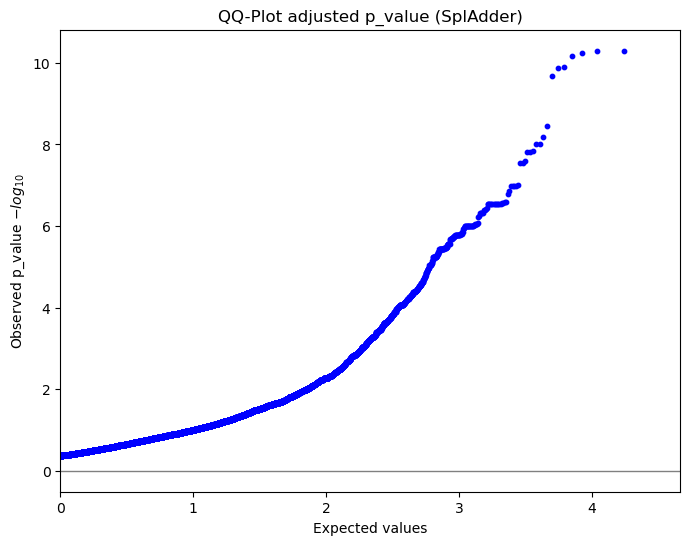

In [19]:
def create_pval_qq_plot(df_str_ase, db_name):
    # Transformation der p-Werte in -log10(p-Werte)
    neg_log10_p_values = -np.log10(df_str_ase['adjusted_p_value'])

    # QQ-Plot-Daten ohne Linie erstellen
    res = stats.probplot(neg_log10_p_values, dist="norm")

    # Manuell plotten
    plt.figure(figsize=(8, 6))
    plt.scatter(res[0][0], res[0][1], color='blue', s=10)
    if db_name == 'SplAdder':
        plt.title("QQ-Plot adjusted p_value (SplAdder)")
    else:
        plt.title("QQ-Plot adjusted p_value (SpliceSeq)")
    plt.xlabel("Expected values")
    plt.ylabel("Observed p_value $-log_{10}$")
    plt.axhline(y=0, color='grey', linestyle='-', linewidth=1)
    plt.xlim(left=0)
    plt.show()

create_pval_qq_plot(df_str_ase_spladder, 'SplAdder')

### Vulcano Plot

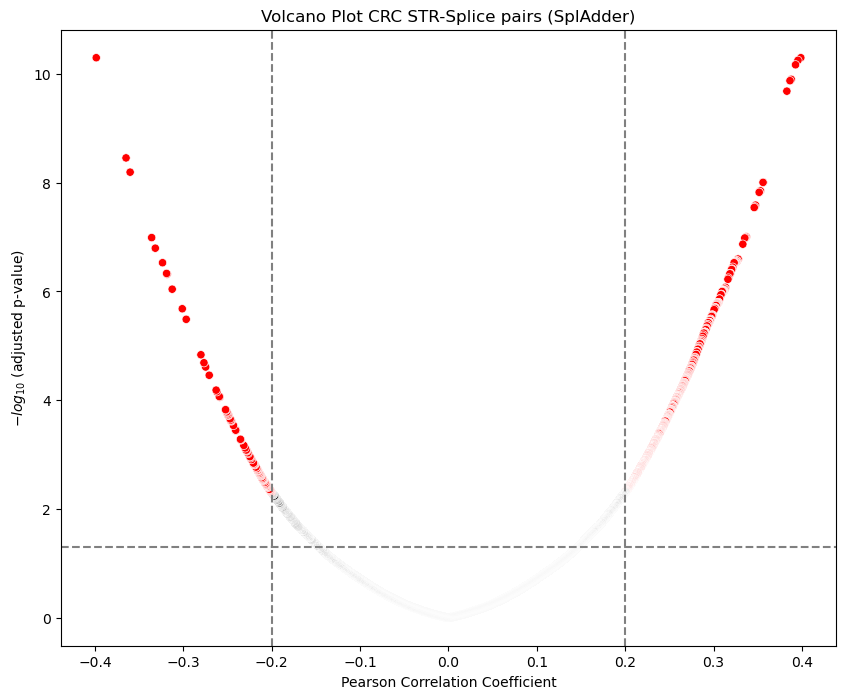

In [61]:
def create_vulcano_plot(df_str_ase, db_type):
    data = df_str_ase[['adjusted_p_value', 'pearson_coefficient']]
    data['-log10(p_value)'] = -np.log10(data['adjusted_p_value'])

    plt.figure(figsize=(10, 8))

    # Define significance thresholds
    correlation_threshold = 0.2
    p_value_threshold = 0.05

    sns.scatterplot(
    data=data, 
        x='pearson_coefficient', 
        y='-log10(p_value)',
        hue=(data['adjusted_p_value'] < p_value_threshold) & (abs(data['pearson_coefficient']) > correlation_threshold),
        palette={True: 'red', False: 'black'},
        legend=False
    )

    plt.axhline(y=-np.log10(p_value_threshold), color='grey', linestyle='--')
    plt.axvline(x=correlation_threshold, color='grey', linestyle='--')
    plt.axvline(x=-correlation_threshold, color='grey', linestyle='--')

    if db_type == "spladder":
        plt.title('Volcano Plot CRC STR-Splice pairs (SplAdder)')
    else:
        plt.title('Volcano Plot CRC STR-Splice pairs (SpliceSeq)')
    plt.xlabel('Pearson Correlation Coefficient')
    plt.ylabel('$-log_{10}$ (adjusted p-value)')

    plt.show()

create_vulcano_plot(df_str_ase_spladder, "spladder")    

### Count number of negative and positive correlations

In [21]:
# Count number of positive correlations
positive_count_spladder = (df_str_ase_spladder_filtered['pearson_coefficient'] > 0).sum()

# Count number of negative correlations
negative_count_spladder = (df_str_ase_spladder_filtered['pearson_coefficient'] < 0).sum()
print(positive_count_spladder, negative_count_spladder)

4906 873


## Analysis for SpliceSeq data

In [22]:
def calculate_str_ase_correlation_spliceseq(pivot_annotated_spliceseq):
    
    df_SpliceSeq_coad = pd.read_csv("/Users/aychaserradj/Downloads/PSI_download_COAD.txt", sep='\t')
    df_SpliceSeq_read = pd.read_csv("/Users/aychaserradj/Downloads/PSI_download_READ.txt", sep='\t')

    df_SpliceSeq_coad['cancer_type'] = 'coad'
    df_SpliceSeq_read['cancer_type'] = 'read'

    df_SpliceSeq = pd.concat([df_SpliceSeq_coad, df_SpliceSeq_read], ignore_index=True)


    df_SpliceSeq.columns = df_SpliceSeq.columns.str.replace('_', '-')
    column_to_move = df_SpliceSeq.pop('cancer-type')
    df_SpliceSeq.insert(10, 'cancer-type', column_to_move)
    cols = df_SpliceSeq.columns[11:]


    df_SpliceSeq = df_SpliceSeq.loc[:, ~df_SpliceSeq.columns.duplicated()]
    cols_str_spliceseq = pivot_annotated_spliceseq.columns[1:].tolist()

    patients_in_metadata_and_spladder = list(set(cols_str_spliceseq).intersection(set(patients_in_metadata)))

    # Get tumor samples that are in STR and ASE data
    cols_str_ase_spliceseq = set(cols).intersection(patients_in_metadata_and_spladder) # 577 patients 
    # Convert set 'cols_str_ase' to list
    cols_str_ase_spliceseq = list(cols_str_ase_spliceseq)

    # Splice annotated str data, ignore first 3 columns that contains 'id', 'gene_name', 'gene_symbol'
    pivot_annotated_spliceseq = pivot_annotated_spliceseq[list(pivot_annotated_spliceseq.columns[:3]) + cols_str_ase_spliceseq]
    # Select columns from SpliceSeq data set, that are also have meta data available 
    df_SpliceSeq = df_SpliceSeq[list(df_SpliceSeq.columns[:11]) + cols_str_ase_spliceseq]

    # Rename column 'symbol' to 'gene_names'
    df_SpliceSeq.rename(columns={'symbol': 'gene_names'}, inplace=True)

    # Merge CRC STR and Splicing data to get STR-ASE pairs based on the gene names
    str_ase_spliceseq = pd.merge(pivot_annotated_spliceseq, df_SpliceSeq, on='gene_names', how='inner')
    # Remove duplicates
    str_ase_spliceseq = str_ase_spliceseq.drop_duplicates(subset=['tmp_id', 'gene_names', 'cancer-type'])
    # Create data set with wanted columns
    str_ase_pairs_spliceseq = str_ase_spliceseq[['tmp_id','gene_names', 'as-id', 'cancer-type']]#


    # Create data set for the correlation analysis with the following columns 
    df_str_ase_spliceseq = pd.DataFrame(columns=['crc_str', 'as_id', 'gene_names', 'cancer_type', 'pearson_coefficient', 'p_value'])

    # iterate over the CRC STR-ASE pairs
    print(len(str_ase_pairs_spliceseq))
    for i in range(len(str_ase_pairs_spliceseq)):
            crc_str = pivot_annotated_spliceseq[pivot_annotated_spliceseq['tmp_id'] == str_ase_pairs_spliceseq['tmp_id'].iloc[i]].iloc[:,3:].iloc[0].tolist()
            # Create data frame of the selected STR and ASE
            filtered_df = df_SpliceSeq[
                (df_SpliceSeq['as-id'] == str_ase_pairs_spliceseq['as-id'].iloc[i]) &
                (df_SpliceSeq['gene_names'] == str_ase_pairs_spliceseq['gene_names'].iloc[i]) &
                (df_SpliceSeq['cancer-type'] == str_ase_pairs_spliceseq['cancer-type'].iloc[i])
            ]
            # Select the columns starting from the 11th column onward and convert to list
            ase = filtered_df.iloc[:, 11:].iloc[0].tolist()
            data = {'crc_str': crc_str,'ase': ase, }
            df = pd.DataFrame(data)
            # Fill 'NaN' values with 0
            df = df.fillna(0)
            # Calculate pearson_coefficient and p_value for each STR-ASE pair
            correlation_coefficient, p_value = pearsonr(df['crc_str'], df['ase'])
            str_ase_spliceseq = {'crc_str': str_ase_pairs_spliceseq['tmp_id'].iloc[i], 
                                'as_id': str_ase_pairs_spliceseq['as-id'].iloc[i],
                                'gene_names': str_ase_pairs_spliceseq['gene_names'].iloc[i],
                                'cancer_type': str_ase_pairs_spliceseq['cancer-type'].iloc[i],
                                'pearson_coefficient': correlation_coefficient,
                                'p_value': p_value}
            df_str_ase_spliceseq = df_str_ase_spliceseq.append(str_ase_spliceseq, ignore_index=True)
            if i % 1000 == 0:
                print(i)
    # Sort data frame by 'pearson_coefficient'        
    df_str_ase_spliceseq = df_str_ase_spliceseq.sort_values(by='pearson_coefficient', ascending=False)

    return df_str_ase_spliceseq, str_ase_pairs_spliceseq, cols_str_ase_spliceseq, df_SpliceSeq

In [23]:
if __name__=='__main__':
    pivot_annotated_spliceseq, pivot_df_spliceseq = create_str_pivot("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/COAD_pt.csv", 
                                  "/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/READ_pt.csv", 
                                  "/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/tral_and_perf_panel_meta_info_updated.tsv")
    # Execute correlation calulation for SpliceSeq 
    df_str_ase_spliceseq, str_ase_pairs_spliceseq, cols_str_ase_spliceseq, df_SpliceSeq = calculate_str_ase_correlation_spliceseq(pivot_annotated_spliceseq)
    
    mask = (df_str_ase_spliceseq['p_value'] >= 0) & (df_str_ase_spliceseq['p_value'] <= 1)
    df_str_ase_spliceseq = df_str_ase_spliceseq[mask]
    # Calculate adjusted p_value 
    df_str_ase_spliceseq['adjusted_p_value'] = multipletests(df_str_ase_spliceseq['p_value'], alpha=0.05, method='fdr_bh')[1].tolist()

    # Create subset based adjsted p_value
    df_str_ase_spliceseq_filtered = df_str_ase_spliceseq[(df_str_ase_spliceseq['adjusted_p_value'] < 0.05)]
    
    # Get functions of genes
    gene_fuction = get_gene_info(df_str_ase_spliceseq_filtered['gene_names'], 'description')
    df_str_ase_spliceseq_filtered['gene_function'] = df_str_ase_spliceseq_filtered['gene_names'].map(gene_fuction)

    df_str_ase_spliceseq['str_ase_pairs'] = df_str_ase_spliceseq['crc_str']+ '; id:' +df_str_ase_spliceseq['as_id'].astype(str) + ';'+ df_str_ase_spliceseq['cancer_type']
    
    # Save created data frames
    df_str_ase_spliceseq.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/SpliceSeq_STR_ASE_pairs_correlation.csv")
    df_str_ase_spliceseq_filtered.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/filtered_SpliceSeq_STR_ASE_pairs_correlation.csv")
    str_ase_pairs_spliceseq.to_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/data/SpliceSeq_STR_ASE_pairs.csv")


30636
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


### P-values Plot

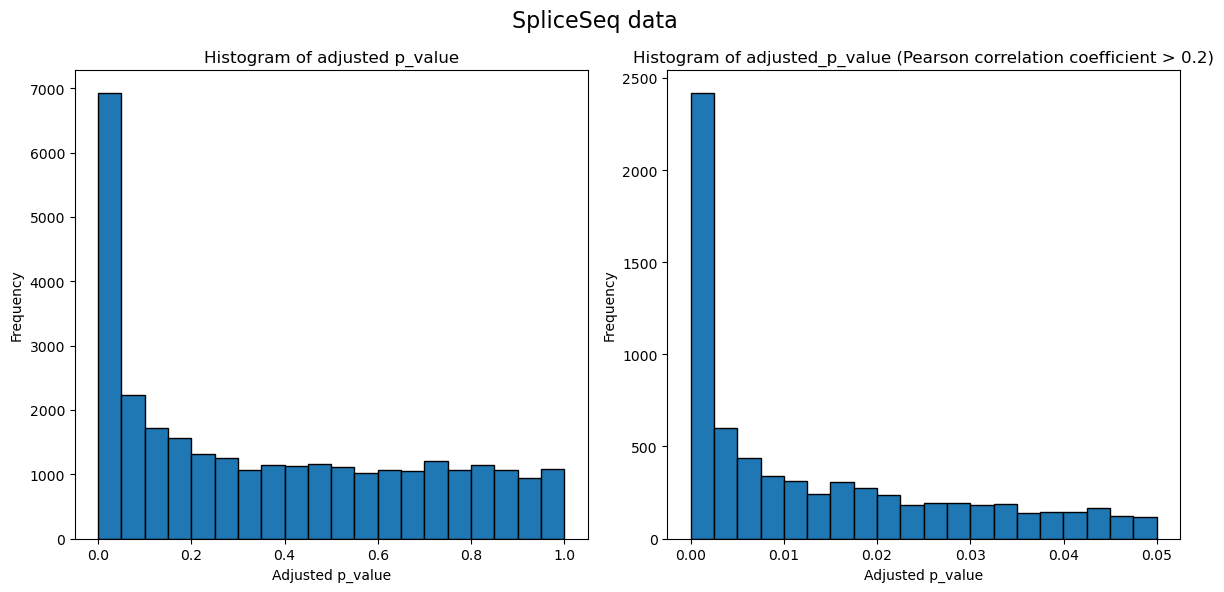

In [24]:
create_pval_figures(df_str_ase_spliceseq, df_str_ase_spliceseq_filtered,'SpliceSeq')    

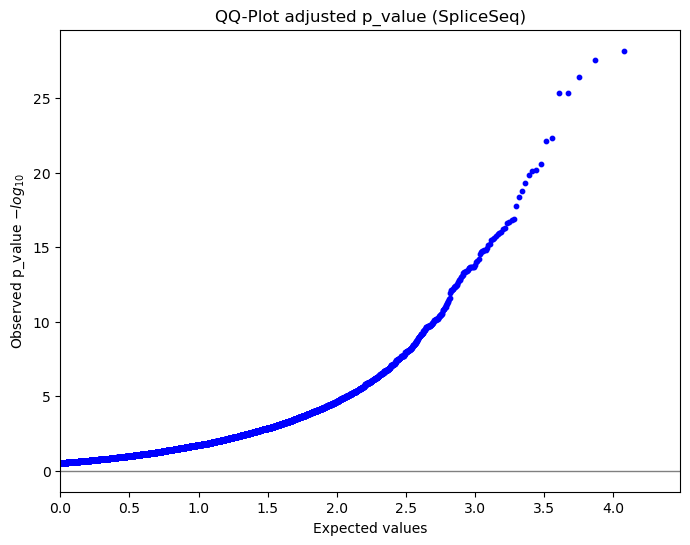

In [25]:
create_pval_qq_plot(df_str_ase_spliceseq, 'SpliceSeq')

### Vulcano Plot significant CRC STR-ASE pairs

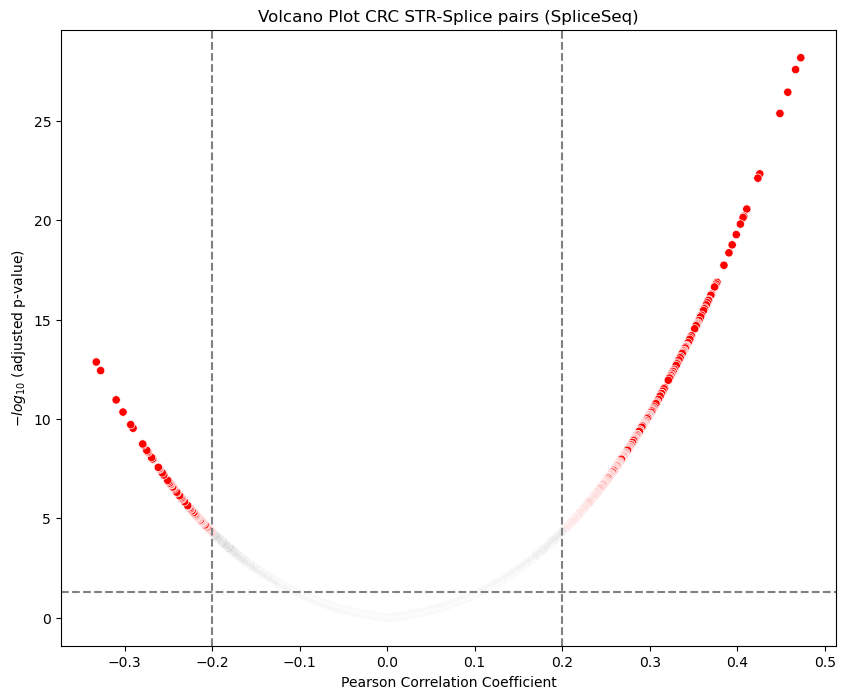

In [64]:
create_vulcano_plot(df_str_ase_spliceseq, "spliceseq")

### Count number of negative and positive correlations 

In [27]:
# Count number of positive correlations
positive_count_spliceseq = (df_str_ase_spliceseq_filtered['pearson_coefficient'] > 0 ).sum() # bedingung adj_pvalue < 0.5
print(positive_count_spliceseq)

# Count number of negative correlations
negative_count_spliceseq = (df_str_ase_spliceseq_filtered['pearson_coefficient'] < 0).sum()
print(negative_count_spliceseq)


4388
2545


In [28]:
df_str_ase_spliceseq_gene_counts_filtered = df_str_ase_spliceseq_filtered['gene_names'].value_counts()
df_str_ase_spliceseq_gene_counts = df_str_ase_spliceseq['gene_names'].value_counts()

In [29]:
df_str_ase_spladder_filtered['gene_name'].value_counts()

RRBP1      128
COL1A2      83
PRKCSH      62
ITGB4       57
CANX        47
          ... 
ENTPD6       1
ENTPD5       1
TCN2         1
RALGAPB      1
LMNA         1
Name: gene_name, Length: 1307, dtype: int64

## Intesect genes Spladder and SpliceSeq 

In [30]:
genes_in_spladder_and_spliceseq =[item for item in df_str_ase_spladder_filtered['gene_name'].unique().tolist() if item in df_str_ase_spliceseq_filtered['gene_names'].unique().tolist()]
len(genes_in_spladder_and_spliceseq)

805

## Intersect Deseq2 differentially expressed genes and genes of the significant STR-ASE pairs

In [31]:
# Import differentially expressed CRC genes 
crc_downregulated = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/expression_analysis/deseq2/data/TCGA_downregulated_gene_info.csv", sep=',')
crc_downregulated = crc_downregulated[crc_downregulated['gene_biotype'] == 'protein_coding']

crc_upregulated = pd.read_csv("/Users/aychaserradj/Desktop/ZHAW/Praktikum/expression_analysis/deseq2/data/TCGA_upregulated_gene_info.csv", sep=',')
crc_upregulated = crc_upregulated[crc_upregulated['gene_biotype'] == 'protein_coding']

# SpliceSeq
spliceseq_str_ase_upregulated = list(set(crc_upregulated['hgnc_symbol']) & set(df_str_ase_spliceseq_filtered['gene_names']))
spliceseq_str_ase_downregulated = list(set(crc_downregulated['hgnc_symbol']) & set(df_str_ase_spliceseq_filtered['gene_names']))

### SplAdder
spladder_str_ase_upregulated = list(set(crc_upregulated['hgnc_symbol']) & set(df_str_ase_spladder_filtered['gene_name']))
spladder_str_ase_downregulated = list(set(crc_downregulated['hgnc_symbol']) & set(df_str_ase_spladder_filtered['gene_name']))


In [32]:
print(len(spliceseq_str_ase_upregulated), len(spliceseq_str_ase_downregulated))

115 136


In [33]:
print(len(spladder_str_ase_upregulated), len(spladder_str_ase_downregulated))

40 31


# Functional Enrichment Analysis

### Enrichment Analysis SplAdder 

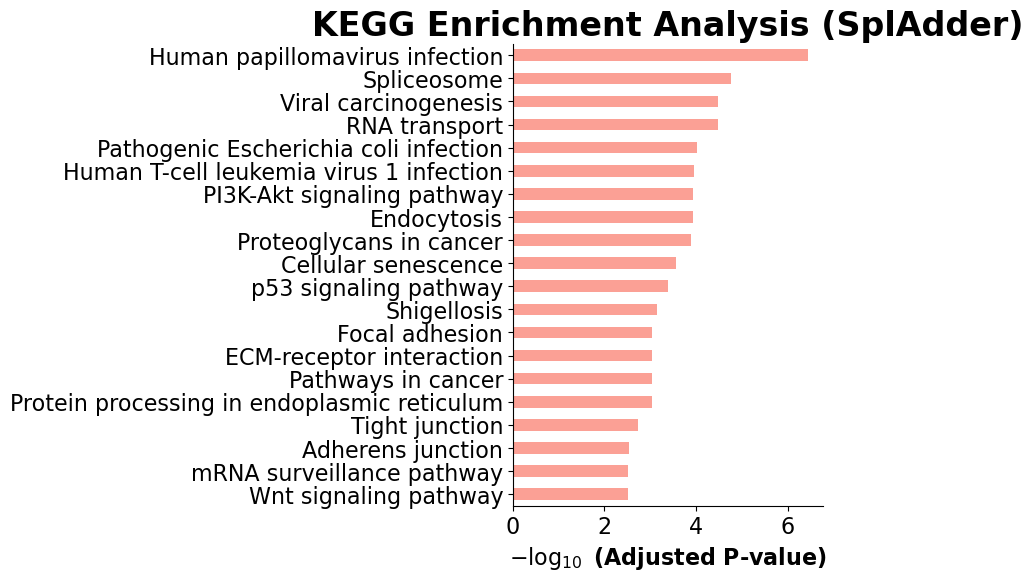

In [34]:
enr_spladder = gp.enrichr(gene_list=list(df_str_ase_spladder[df_str_ase_spladder['adjusted_p_value'] < 0.05]['gene_name'].unique()), gene_sets='KEGG_2021_Human', outdir='enrich/enrichr_kegg_spladder')
gp.barplot(enr_spladder.res2d, title='KEGG Enrichment Analysis (SplAdder)', top_term=20)
plt.show()

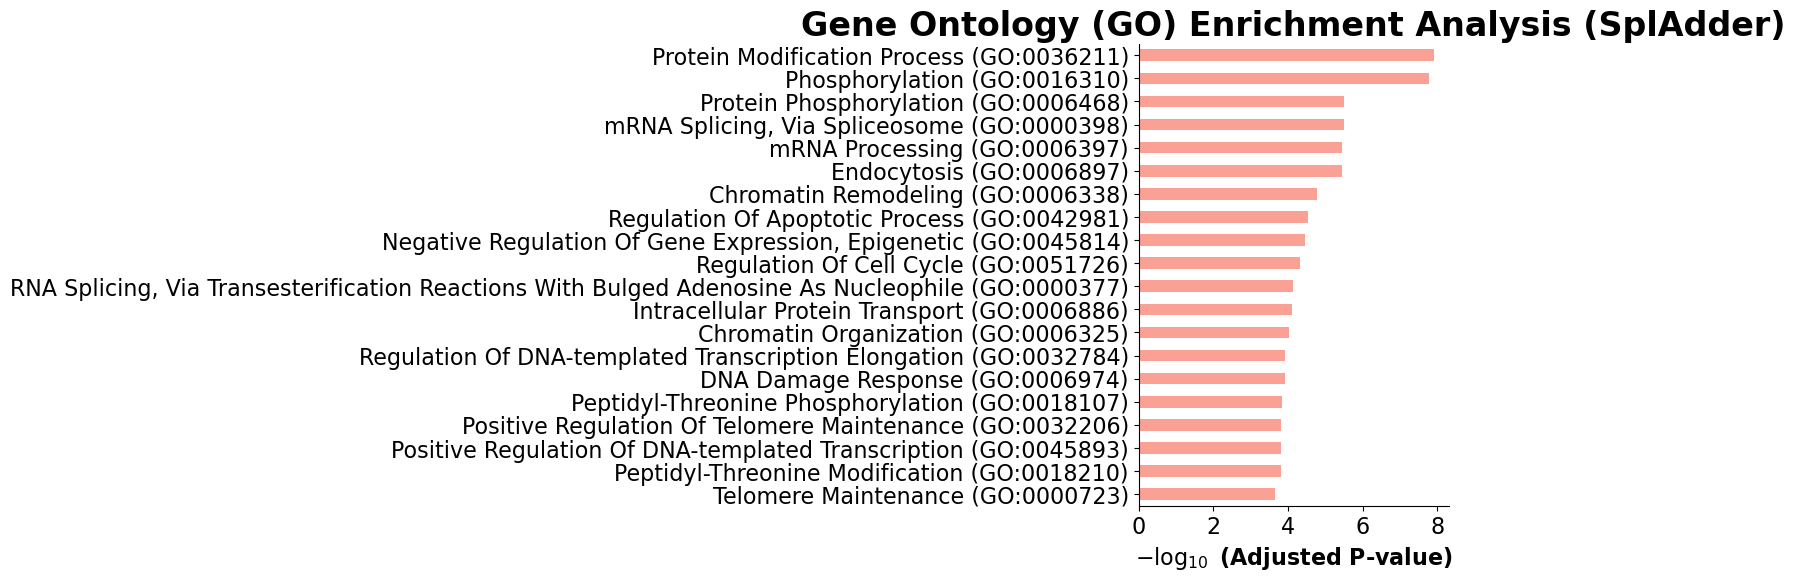

In [35]:
go_spladder = gp.enrichr(gene_list=list(df_str_ase_spladder[df_str_ase_spladder['adjusted_p_value'] < 0.05]['gene_name'].unique()), gene_sets='GO_Biological_Process_2023', outdir='enrich/enrichr_go_spladder')
gp.barplot(go_spladder.res2d, title='Gene Ontology (GO) Enrichment Analysis (SplAdder)', top_term=20)
plt.show()

### Enrichment Analysis SpliceSeq

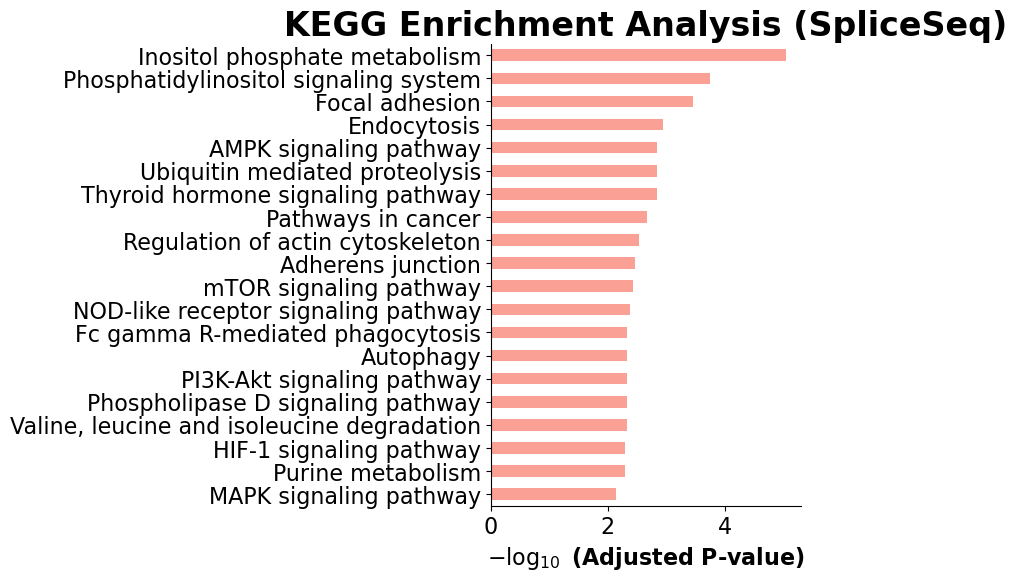

In [36]:
# GO_Biological_Process_2023
# KEGG_2021_Human
enr_spliceseq = gp.enrichr(gene_list=list(df_str_ase_spliceseq[df_str_ase_spliceseq['adjusted_p_value'] < 0.05]['gene_names'].unique()), gene_sets='KEGG_2021_Human', outdir='enrich/enrichr_kegg_spliceseq')
gp.barplot(enr_spliceseq.res2d, title='KEGG Enrichment Analysis (SpliceSeq)', top_term=20)
plt.show()

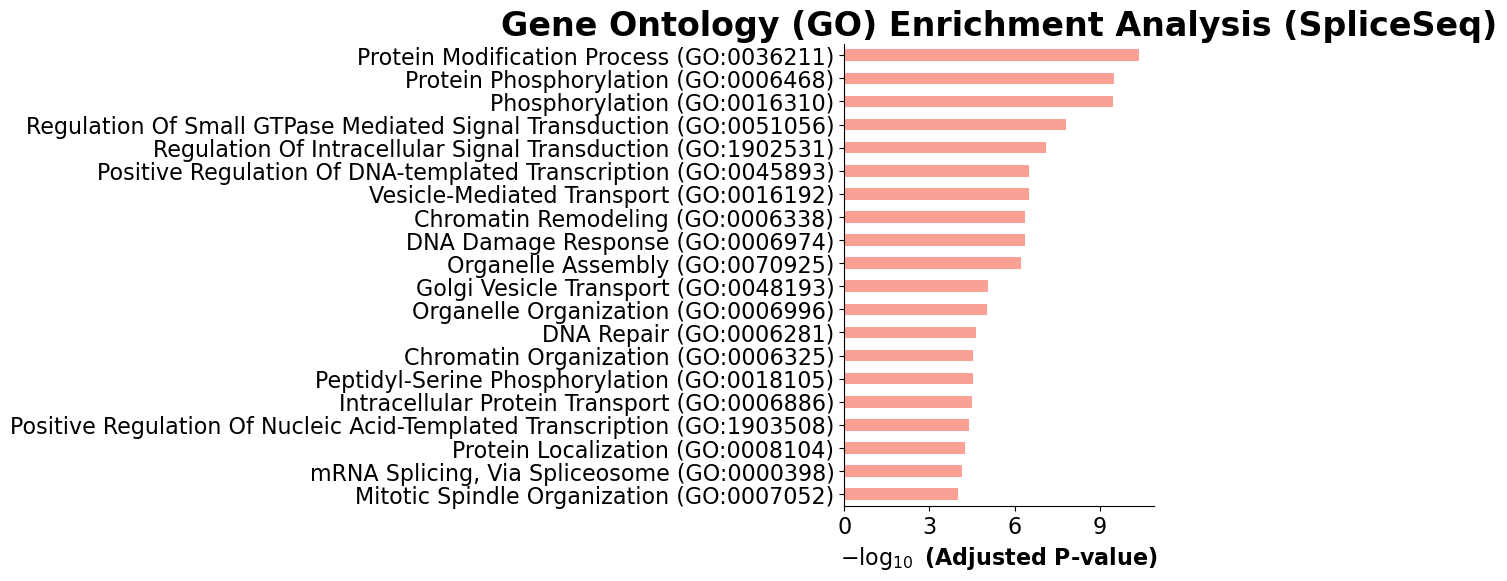

In [37]:
# GO_Biological_Process_2023
# KEGG_2021_Human
go_spliceseq = gp.enrichr(gene_list=list(df_str_ase_spliceseq[df_str_ase_spliceseq['adjusted_p_value'] < 0.05]['gene_names'].unique()), gene_sets='GO_Biological_Process_2023', outdir='enrich/enrichr_go_spliceseq')
gp.barplot(go_spliceseq.res2d, title='Gene Ontology (GO) Enrichment Analysis (SpliceSeq)', top_term=20)
plt.show()

## Covariance 

In [38]:
# Read CRC patients meta data
# Encode values into numeric values
crc_samples_meta_data['ad_race'] = crc_samples_meta_data['ad_race'].map({'NOT': 0, 'EUR':1, 'EAS':2, 'AFR': 3})
crc_samples_meta_data['gender'] = crc_samples_meta_data['gender'].map({'male': 0, 'female':1})
crc_samples_meta_data['ad_race'] = crc_samples_meta_data['ad_race'].map({'NOT': 0, 'EUR':1, 'EAS':2, 'AFR': 3})

# Select patients that have ASE information avaiable 
crc_samples_meta_data_spladder = crc_samples_meta_data[crc_samples_meta_data['patient'].isin(cols_str_ase_spladder)]
crc_samples_meta_data_spliceseq= crc_samples_meta_data[crc_samples_meta_data['patient'].isin(cols_str_ase_spliceseq)]

df_SplAdder_selected = df_SplAdder[crc_samples_meta_data_spladder['patient'].to_list()]
df_SpliceSeq_selected = df_SpliceSeq[crc_samples_meta_data_spliceseq['patient'].to_list()]

pivot_annotated_spliceseq = pivot_annotated_spliceseq[['tmp_id', 'gene_names', 'gene_ensembl_ids'] + cols_str_ase_spliceseq]

## Partial correlation

In [74]:
partial_corr_results_spliceseq = pd.DataFrame(columns=['gene_names', 'cancer_type', 'pearson_coefficient', 'p_value'])

for i in range(len(df_str_ase_spliceseq)):
        df = pd.DataFrame({ 'psi':df_SpliceSeq[
                            (df_SpliceSeq['as-id'] == str_ase_pairs_spliceseq['as-id'].iloc[i]) &
                            (df_SpliceSeq['gene_names'] == str_ase_pairs_spliceseq['gene_names'].iloc[i]) &
                            (df_SpliceSeq['cancer-type'] == str_ase_pairs_spliceseq['cancer-type'].iloc[i])].iloc[:, 11:].iloc[0].tolist(),
                            'str_len': pivot_annotated_spliceseq[pivot_annotated_spliceseq['tmp_id'] == str_ase_pairs_spliceseq['tmp_id'].iloc[i]].iloc[:,3:].iloc[0].tolist(), #586 statt 576
                            'race': crc_samples_meta_data_spliceseq['ad_race'],
                            'gender': crc_samples_meta_data_spliceseq['gender'],
                            'age_at_index': crc_samples_meta_data_spliceseq['age_at_index']
                            })
        df = df.fillna(0)
        df = df.astype({'psi': 'float64', 'str_len': 'float64', 'race': 'int64', 'gender': 'int64', 'age_at_index': 'int64'})
        
        partial_corr = pg.partial_corr(data=df, x='psi', y='str_len', covar=['race','gender','age_at_index'])
        print(float(partial_corr['r']), float(partial_corr['p-val']))
        
        partial_corr_results_spliceseq = partial_corr_results_spliceseq.append({'crc_str': str_ase_pairs_spliceseq['tmp_id'].iloc[i], 
                            'as_id': str_ase_pairs_spliceseq['as-id'].iloc[i],
                            'gene_names': str_ase_pairs_spliceseq['gene_names'].iloc[i],
                            'cancer_type': str_ase_pairs_spliceseq['cancer-type'].iloc[i],
                            'pearson_coefficient': float(partial_corr['r']),
                            'p_value': float(partial_corr['p-val'])}, ignore_index =True)

0.09406282600535752 0.024341320899317547
-0.11779906895269268 0.00475047240311223
0.09082143475137011 0.029721858595664345
-0.11001122689143535 0.008397922150971574
0.00986947835890244 0.8136346794308742
0.0015077365170673243 0.97127236959113
0.07145346448057578 0.0874766582474745
-0.08002009409787939 0.05557386976649568
0.057972041879145585 0.16579686882746647
-0.05146582625103123 0.21866561910988241
0.10552730863460044 0.011484639630180283
0.030958257773126486 0.4595307176423885
0.035586102821917605 0.3951868881939038
-0.03735307271668721 0.37212761962912067
0.12215254550108161 0.0034048618187712664
-0.12002115458024287 0.004013107897733021
-0.022176181607574532 0.5962877076435205
-0.08102599598133496 0.05256151556340839
0.14012011871974736 0.0007698971178862126
-0.11698374741188046 0.00505031929770996
0.06896505588087405 0.099105756836024
-0.04275419801450236 0.30694304508725123
0.07756821608474546 0.06352134773147328
0.0703627348833847 0.09243119004006456
0.02776190048010677 0.5071

In [75]:
mask = (partial_corr_results_spliceseq['p_value'] >= 0) & (partial_corr_results_spliceseq['p_value'] <= 1)
partial_corr_results_spliceseq = partial_corr_results_spliceseq[mask]
partial_corr_results_spliceseq['adjusted_p_value'] = multipletests(partial_corr_results_spliceseq['p_value'], alpha=0.05, method='fdr_bh')[1].tolist()
partial_corr_results_spliceseq

,gene_names,cancer_type,pearson_coefficient,p_value,crc_str,as_id,adjusted_p_value
0,GTPBP4,coad,0.094063,0.024341,chr10_1000869,10607.0,0.085022
1,GTPBP4,read,-0.117799,0.004750,chr10_1000869,10607.0,0.026185
2,GTPBP4,coad,0.090821,0.029722,chr10_1009084,10607.0,0.097819
3,GTPBP4,read,-0.110011,0.008398,chr10_1009084,10607.0,0.039445
4,GTPBP4,coad,0.009869,0.813635,chr10_1014160,10607.0,0.883770
...,...,...,...,...,...,...,...
30240,KRBOX4,read,-0.042947,0.304767,chrX_46472998,88886.0,0.482271
30241,KRBOX4,coad,-0.027551,0.510418,chrX_46473407,88886.0,0.668328
30242,KRBOX4,read,0.019552,0.640471,chrX_46473407,88886.0,0.766051
30243,RBM10,coad,0.141894,0.000658,chrX_47171068,88905.0,0.006105


In [76]:
partial_corr_results_spliceseq[(partial_corr_results_spliceseq['adjusted_p_value'] < 0.05)]

,gene_names,cancer_type,pearson_coefficient,p_value,crc_str,as_id,adjusted_p_value
1,GTPBP4,read,-0.117799,0.004750,chr10_1000869,10607.0,0.026185
3,GTPBP4,read,-0.110011,0.008398,chr10_1009084,10607.0,0.039445
10,ERLIN1,coad,0.105527,0.011485,chr10_100152407,12788.0,0.049839
14,CWF19L1,coad,0.122153,0.003405,chr10_100267520,12791.0,0.020407
15,CWF19L1,read,-0.120021,0.004013,chr10_100267520,12791.0,0.023044
...,...,...,...,...,...,...,...
30231,KDM6A,coad,0.192717,0.000003,chrX_45069631,88878.0,0.000102
30235,KDM6A,coad,0.180353,0.000014,chrX_45082720,88878.0,0.000316
30237,KDM6A,coad,0.156904,0.000163,chrX_45090707,88878.0,0.002116
30243,RBM10,coad,0.141894,0.000658,chrX_47171068,88905.0,0.006105


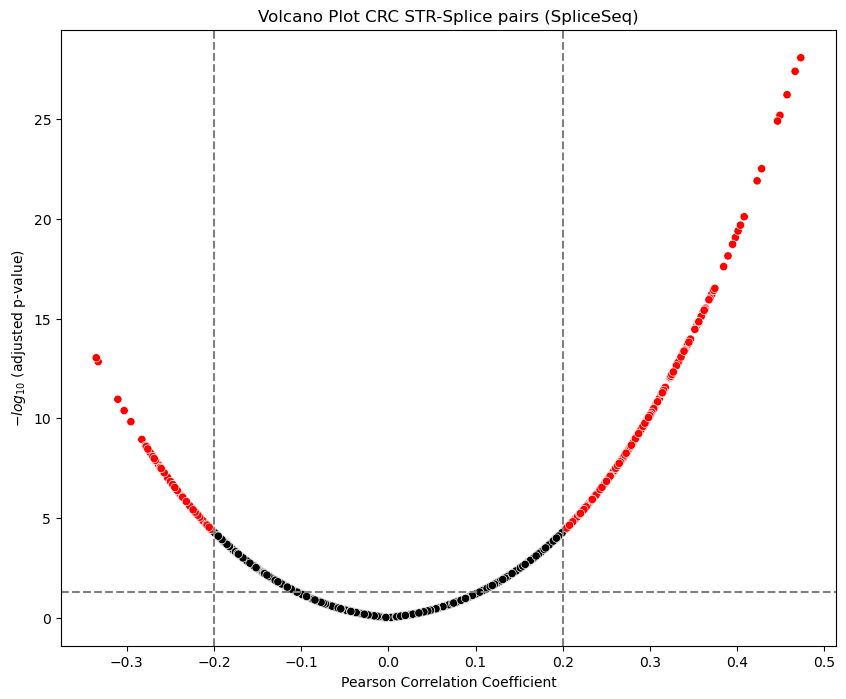

In [77]:
create_vulcano_plot(partial_corr_results_spliceseq, "splicseq")

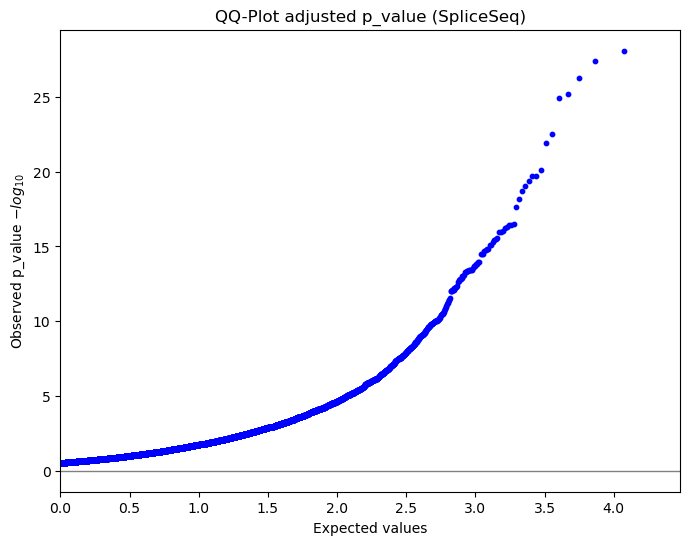

In [78]:
create_pval_qq_plot(partial_corr_results_spliceseq, 'SpliceSeq')

In [65]:
regression_results_spladder = pd.DataFrame(columns=['splicing_event', 'crc_str', 'gene_name', 'pearson_coefficient', 'p_value' ])

for i in range(len(df_str_ase_spladder)):
    # Extract the relevant data from df_SplAdder and pivot_annotated
    df = pd.DataFrame({
        'psi': df_SplAdder[df_SplAdder['SpliceEvent'] == df_str_ase_spladder['splice_event'].iloc[i]].iloc[:, 15:].iloc[0].tolist(),
        'str_len': pivot_annotated[pivot_annotated['tmp_id'] == df_str_ase_spladder['crc_str'].iloc[i]].iloc[:,3:].iloc[0].tolist(),
        'race': crc_samples_meta_data_spladder['ad_race'],
        'gender': crc_samples_meta_data_spladder['gender'],
        'age_at_index': crc_samples_meta_data_spladder['age_at_index']
    })

    # Fill missing values
    df = df.fillna(0)
    
    # Convert all columns to numeric data types
    df = df.astype({'psi': 'float64', 'str_len': 'float64', 'race': 'int64', 'gender': 'int64', 'age_at_index': 'int64'})
    
    # Calculate die partial correlation
    partial_corr = pg.partial_corr(data=df, x='psi', y='str_len', covar=['race', 'gender', 'age_at_index'])
    
    # Extract die Korrelation and p-value
    corr = float(partial_corr['r'])
    p_value = float(partial_corr['p-val'])
    
    # Add information to DataFrame regression_results_spladder 
    regression_results_spladder = regression_results_spladder.append({
        'splicing_event': df_str_ase_spladder['splice_event'].iloc[i],
        'crc_str': df_str_ase_spladder['crc_str'].iloc[i],
        'gene_name': df_str_ase_spladder['gene_name'].iloc[i],
        'pearson_coefficient': corr,
        'p_value': p_value,
    }, ignore_index=True)
    
    # Counter to get progress of calculation
    if i % 1000 == 0:
        print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000


In [66]:
mask = (regression_results_spladder['p_value'] >= 0) & (regression_results_spladder['p_value'] <= 1)
regression_results_spladder = regression_results_spladder[mask]
regression_results_spladder['adjusted_p_value'] = multipletests(regression_results_spladder['p_value'], alpha=0.05, method='fdr_bh')[1].tolist()

In [67]:
regression_results_spladder

,splicing_event,crc_str,gene_name,pearson_coefficient,p_value,adjusted_p_value
0,exon_skip_365010,chr22_36254863,APOL1,0.401758,1.144148e-15,4.591706e-11
1,intron_retention_93340,chr22_36254863,APOL1,0.398003,2.216788e-15,4.591706e-11
2,intron_retention_93335,chr22_36254863,APOL1,0.394836,3.847417e-15,5.976963e-11
3,intron_retention_93338,chr22_36254863,APOL1,0.389870,9.027490e-15,1.121936e-10
4,intron_retention_93336,chr22_36254863,APOL1,0.388148,1.209305e-14,1.252437e-10
...,...,...,...,...,...,...
62135,intron_retention_102246,chr3_194431078,ATP13A3,-0.329200,1.005160e-10,2.402333e-07
62136,intron_retention_118270,chr7_856438,SUN1,-0.334949,4.517740e-11,1.276056e-07
62137,intron_retention_102246,chr3_194460742,ATP13A3,-0.357219,1.737420e-12,8.996941e-09
62138,intron_retention_118270,chr7_857795,SUN1,-0.365608,4.757953e-13,3.695740e-09


In [68]:
regression_results_spladder_genes = regression_results_spladder[regression_results_spladder['adjusted_p_value'] < 0.05]['gene_name'].unique()
regression_results_spliceseq_genes = partial_corr_results_spliceseq[(partial_corr_results_spliceseq['adjusted_p_value'] < 0.05)]['gene_names'].unique()

print(f"Number genes partial correlation (SplAdder): {len(regression_results_spladder_genes)}")
print(f"Number genes partial correlation (SpliceSeq): {len(regression_results_spliceseq_genes)}")

Number genes partial correlation (SplAdder): 1284
Number genes partial correlation (SpliceSeq): 2885


In [69]:
spladder_up = [item for item in crc_upregulated['hgnc_symbol'] if item in regression_results_spladder_genes]
spladder_down = [item for item in crc_downregulated['hgnc_symbol'] if item in regression_results_spladder_genes]

In [70]:
spliceseq_up = [item for item in crc_upregulated['hgnc_symbol'] if item in regression_results_spliceseq_genes]
spliceseq_down = [item for item in crc_downregulated['hgnc_symbol'] if item in regression_results_spliceseq_genes]

In [71]:
len([item for item in spladder_down if item in spliceseq_down])
len([item for item in spladder_up if item in spliceseq_up])
len([item for item in list(df_str_ase_spladder_filtered['gene_name'].unique()) if item in list(df_str_ase_spliceseq_filtered['gene_names'].unique())])

805

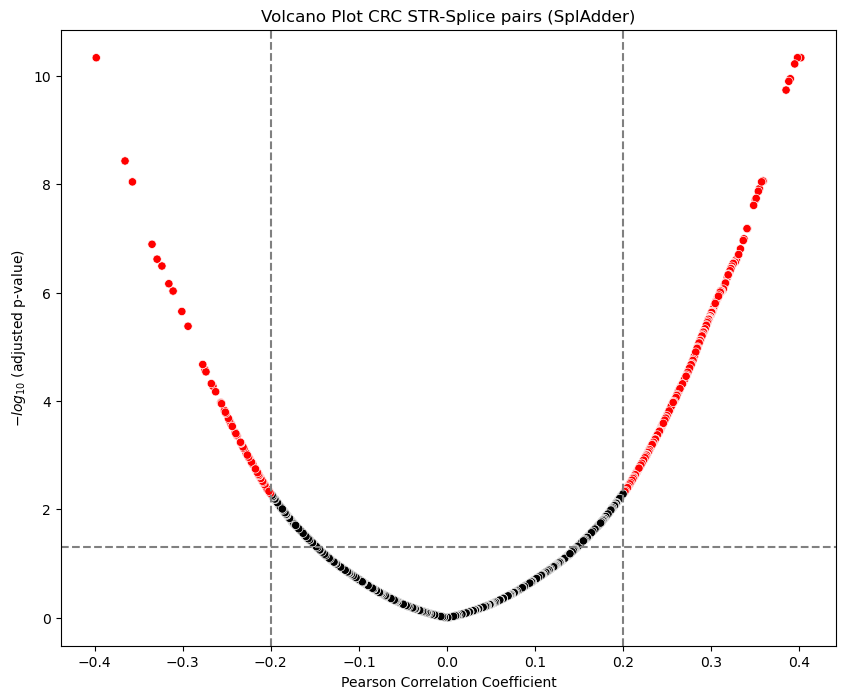

In [72]:
create_vulcano_plot(regression_results_spladder, "spladder")


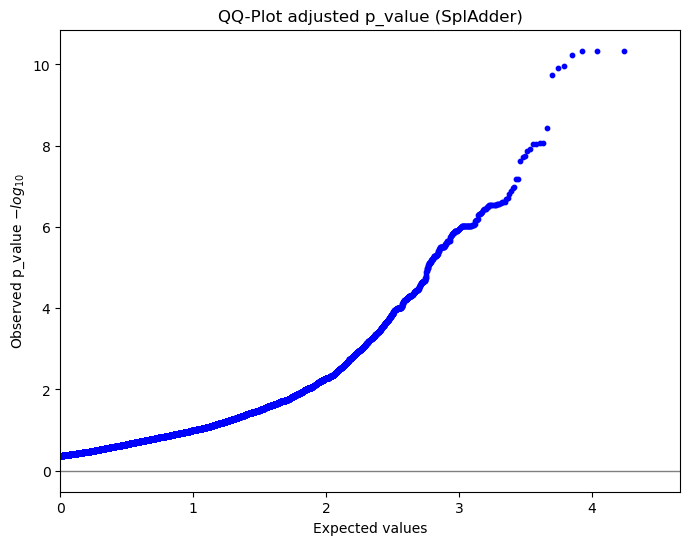

In [73]:
create_pval_qq_plot(regression_results_spladder, 'SplAdder')

## Get ASE type of correlations

In [49]:
neue_werte = {'AA': 'Alternate acceptor site',
              'AD': 'Alternate donor site',
              'ES': 'Exon Skipping',
              'ME': 'Mutally exclusive exons',
              'RI': 'Retained intron',
              'AP': 'Alternate promoter',
              'AT': 'Alternate terminator'}
df_SpliceSeq['splice-type'] = df_SpliceSeq['splice-type'].replace(neue_werte)

neue_werte = {'A3': 'Alternate acceptor site',
              'A5': 'Alternate donor site',
              'ES': 'Exon Skipping',
              'ME': 'Mutally exclusive exons',
              'IR': 'Retained intron'}
df_SplAdder['SpliceType'] = df_SplAdder['SpliceType'].replace(neue_werte)

In [50]:
regression_results_spladder_filtered = regression_results_spladder[regression_results_spladder['adjusted_p_value'] < 0.05]
spladder_as_type = []
for event in regression_results_spladder_filtered['splicing_event'].to_list():
    # Finde den as_type für das aktuelle splicing_event
    as_type = df_SplAdder.loc[df_SplAdder['SpliceEvent'] == event, 'SpliceType']
    spladder_as_type.append(as_type.iloc[0])

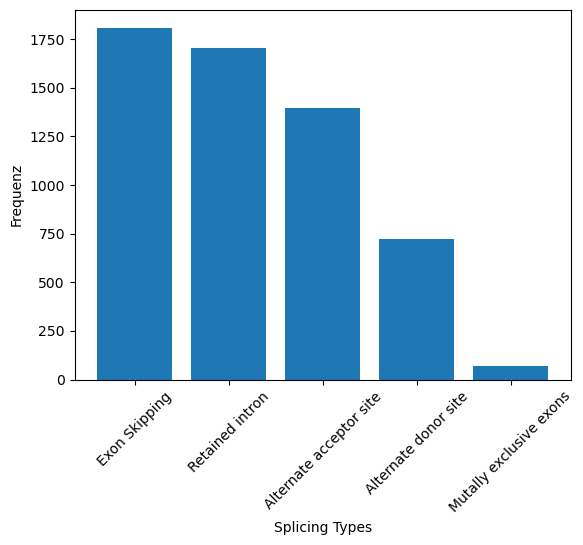

In [51]:
spladder_as_type_frequencies = Counter(spladder_as_type)

spladder_as_type_frequencies_frequencies = dict(Counter(spladder_as_type_frequencies))

# Balkendiagramm erstellen
plt.bar(spladder_as_type_frequencies_frequencies.keys(), spladder_as_type_frequencies_frequencies.values())

plt.xticks(rotation=45)

# Diagramm beschriften
plt.xlabel('Splicing Types')
plt.ylabel('Frequenz')
plt.title('')

# Diagramm anzeigen
plt.show()

In [52]:
regression_results_spliceseq_filtered = partial_corr_results_spliceseq[partial_corr_results_spliceseq['adjusted_p_value'] < 0.05]
spliceseq_as_type = []
for index, row in regression_results_spliceseq_filtered.iterrows():
    as_type_spliceseq = df_SpliceSeq.loc[(df_SpliceSeq['gene_names'] == row['gene_names']) & (df_SpliceSeq['cancer-type'] == row['cancer_type']) & (df_SpliceSeq['as-id'] == row['as_id']), 'splice-type'].iloc[0]
    spliceseq_as_type.append(as_type_spliceseq)

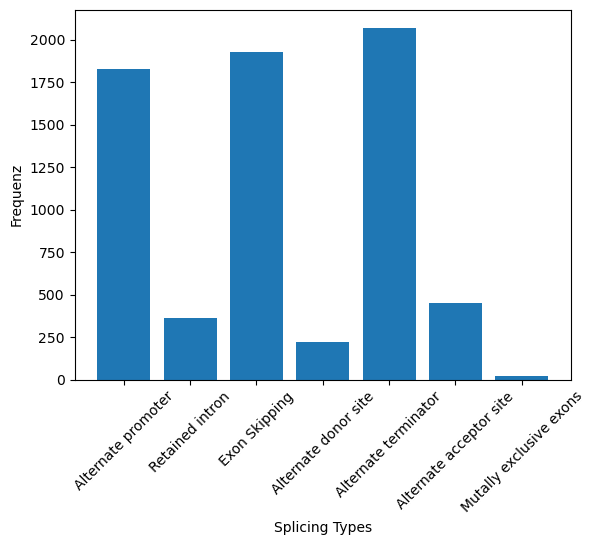

In [53]:
spliceseq_as_type_frequencies = Counter(spliceseq_as_type)

spliceseq_as_type_frequencies_frequencies = dict(Counter(spliceseq_as_type_frequencies))

# Balkendiagramm erstellen
plt.bar(spliceseq_as_type_frequencies_frequencies.keys(), spliceseq_as_type_frequencies_frequencies.values())

plt.xticks(rotation=45)

# Diagramm beschriften
plt.xlabel('Splicing Types')
plt.ylabel('Frequenz')
plt.title('')

# Diagramm anzeigen
plt.show()

In [54]:
#spliceseq_as_type_frequencies_frequencies # 6758
spliceseq_as_type_frequencies_frequencies = dict(spliceseq_as_type_frequencies)
spladder_as_type_frequencies_frequencies = dict(spladder_as_type_frequencies)
spladder_as_type_frequencies_frequencies['Alternate promoter'], spladder_as_type_frequencies_frequencies['Alternate terminator'] = 0, 0

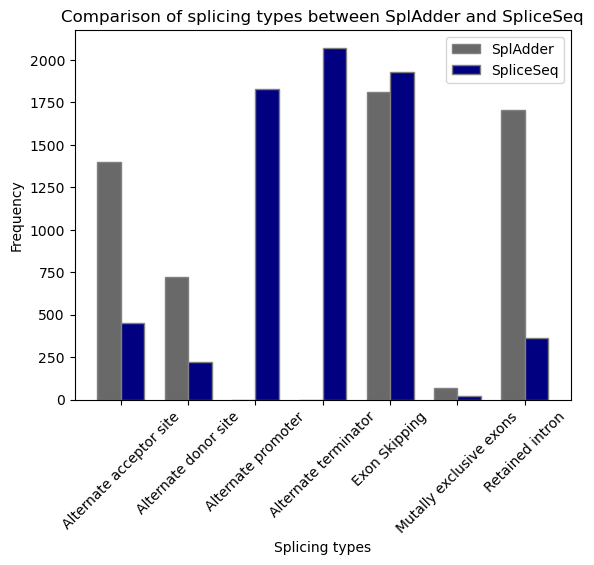

In [55]:
# Beispiel-Dictionaries
dict1 = spladder_as_type_frequencies_frequencies
dict2 = spliceseq_as_type_frequencies_frequencies

# Sortiere die Schlüssel, um sicherzustellen, dass die Balken in der gleichen Reihenfolge angezeigt werden
keys = sorted(dict1.keys())

# Werte aus den Dictionaries extrahieren
values_dict1 = [dict1[key] for key in keys]
values_dict2 = [dict2[key] for key in keys]

# Breite der Balken
bar_width = 0.35

# Positionen der Balken für die x-Achse
r1 = range(len(keys))
r2 = [x + bar_width for x in r1]

plt.xticks(rotation=45)

# Balkendiagramme erstellen
plt.bar(r1, values_dict1, color='dimgrey', width=bar_width, edgecolor='grey', label='SplAdder')
plt.bar(r2, values_dict2, color='navy', width=bar_width, edgecolor='grey', label='SpliceSeq')

# Beschriftung der Achsen und Titel
plt.xlabel('Splicing types')
plt.ylabel('Frequency')
plt.title('Comparison of splicing types between SplAdder and SpliceSeq')
plt.xticks([r + bar_width/2 for r in range(len(keys))], keys)

# Legende anzeigen
plt.legend()

# Diagramm anzeigen
plt.show()

# Functional Enrichment Analysis for partial correlation 

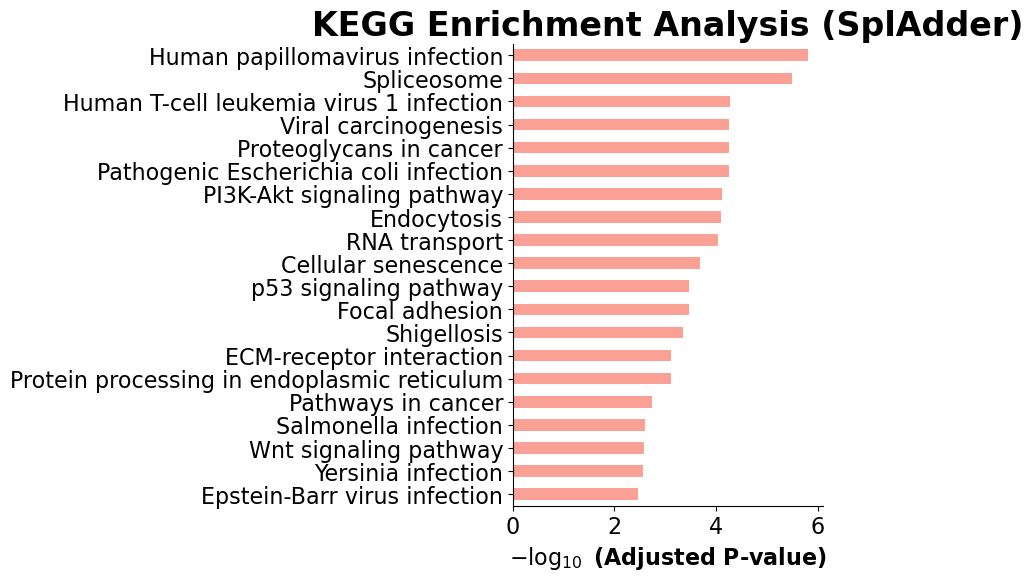

In [56]:
enr_spladder_partial = gp.enrichr(gene_list=list(regression_results_spladder_genes), gene_sets='KEGG_2021_Human', outdir='enrich/enrichr_kegg_spladder_partial')
gp.barplot(enr_spladder_partial.res2d, title='KEGG Enrichment Analysis (SplAdder)', top_term=20)
plt.show()

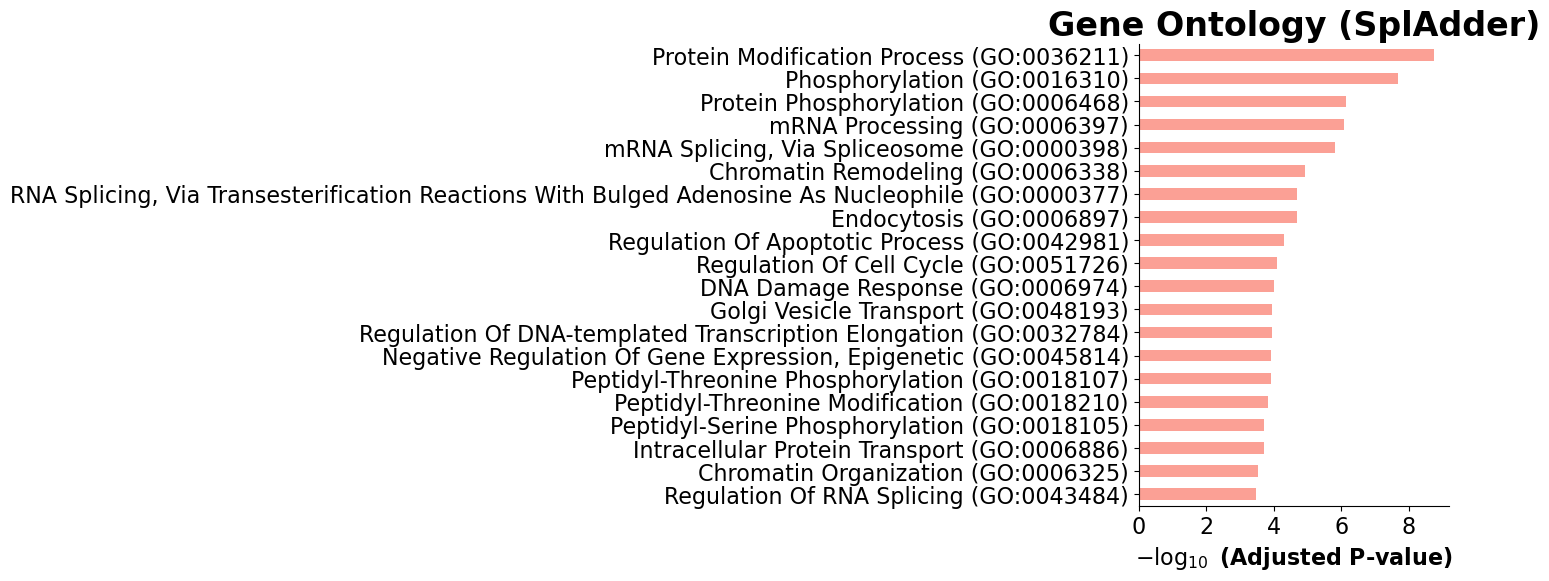

In [57]:
enr_spladder_partial = gp.enrichr(gene_list=list(regression_results_spladder_genes), gene_sets='GO_Biological_Process_2023', outdir='enrich/enrichr_go_spladder_partial')
gp.barplot(enr_spladder_partial.res2d, title='Gene Ontology (SplAdder)', top_term=20)
plt.show()

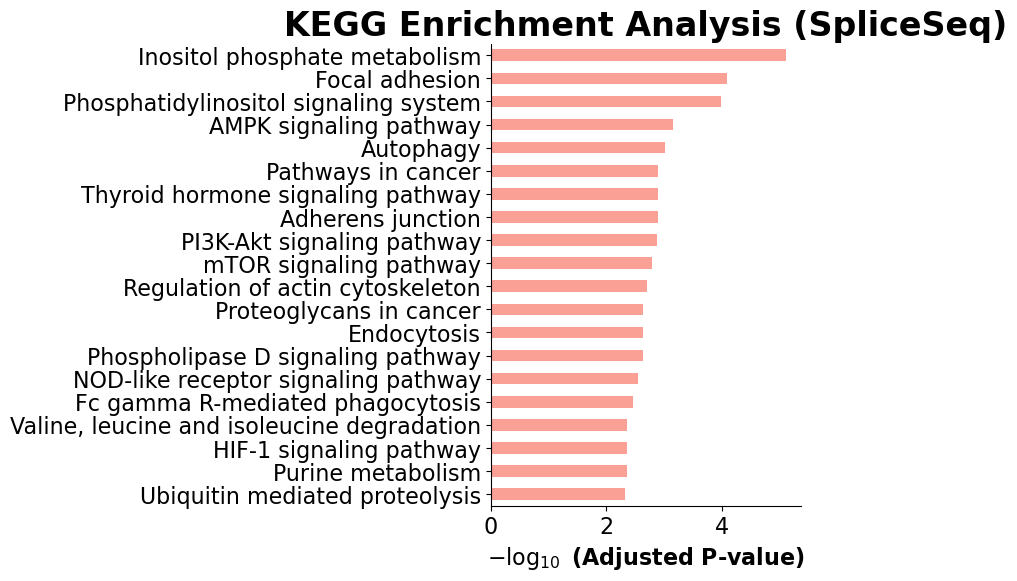

In [58]:
enr_spliceseq_partial = gp.enrichr(gene_list=list(regression_results_spliceseq_genes), gene_sets='KEGG_2021_Human', outdir='enrich/enrichr_kegg_spliceseq_partial')
gp.barplot(enr_spliceseq_partial.res2d, title='KEGG Enrichment Analysis (SpliceSeq)', top_term=20)
plt.show()

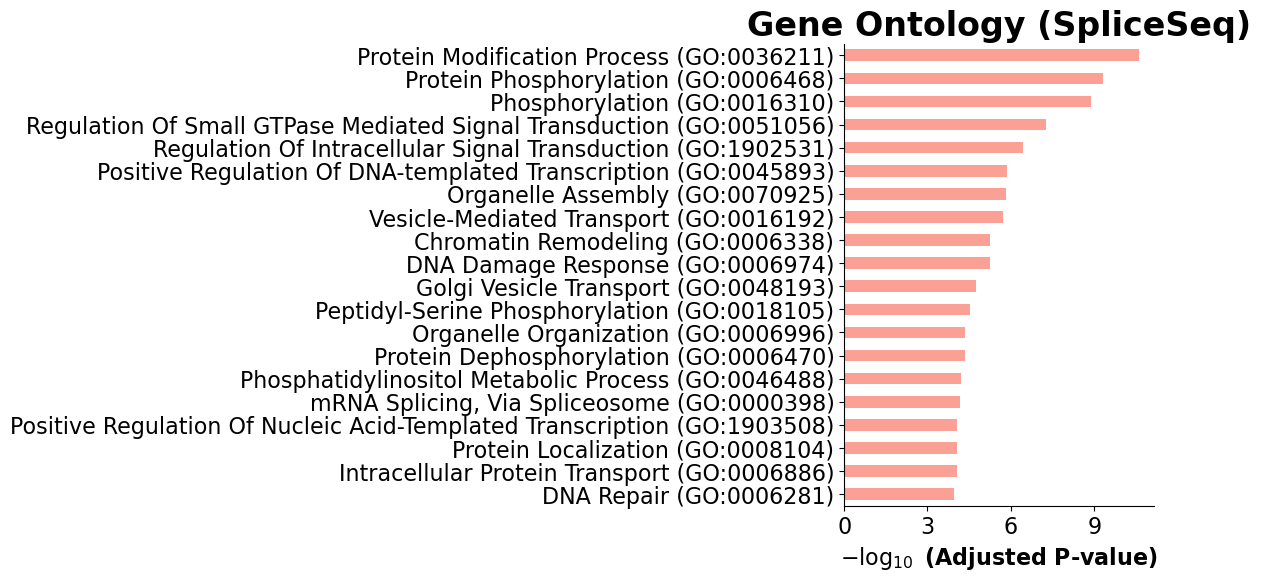

In [59]:
enr_spliceseq_partial = gp.enrichr(gene_list=list(regression_results_spliceseq_genes), gene_sets='GO_Biological_Process_2023', outdir='enrich/enrichr_go_spliceseq_partial')
gp.barplot(enr_spliceseq_partial.res2d, title='Gene Ontology (SpliceSeq)', top_term=20)
plt.show()